# Storing and operating on bitstrings on the quantum computer

### Contributors
Łukasz Herok, James Wootton

This tutorial bases heavily upon "Comparing Strings with Quantum Superpositon" tutorial by Rudy Raymond.

## Motivation
The aim of this tutorial is to show in details how to store bitstring in the quantum computer and how we can manipulate it.

## Encoding 7 bits on 4 qubits
The bitstring is a string of zero and ones, that represents some kind of information. This colud be interpreted as number, eg. interpreting as binary numer `1000001` is `65`, or interpreting as ASCII it is letter `A`.
For the classcial computer to store this information we need to use 7 bits.

For quantum computer, using the *Quantum Superpostion* a bitstring could be encoded and store in more comperhensive fasion. We only need to get the set of unique states that can describe the bitstring of given length. The ways is to write down the bistring in notation where first bits describes the position in a bitstring and the last one the data: zero or one. For our `1000001` it will be: 

```
   bs | pppd 
  ----|------ 
    1 | 0001 
    0 | 0010
    0 | 0100
    0 | 0110
    0 | 1000
    0 | 1010
    0 | 1100
    1 | 1111
```
So as can we see we need only 4 qubits to store the 7 length bitstring. In a quantum notation it will be:

$$ |bs> = \alpha|0001> + \alpha|0001> + ... + \alpha|1100> + \alpha|1111>$$

where $\alpha$ is the probability amplitude that needs to meet the requirement $\alpha_1^2 + ... + \alpha_n^2  = 1$. 

For example:
$ \alpha|0001>$ tells us that there is probability of $|\alpha|^2$ that the system is in state $|0001>$, and there is $0$ probability that it is in the state $|0000>$, as it doesn't occure in the equation. So we can be sure that on the first postion (`000`) of the bitstring there should be `1`. In the real quantum system, making the multiple measurements of its state will give us as a count for the every of the shown states and no measurements for the state that was not listed, that's the way that we decode the bitstring from the quantum chip. Of course in the real system there are noises, so there is a possbility that we also get the counts for the state that was not set up in the system eg. for $|0000>$, but we exlude it as in a muliple measurements it will have much lower probablity then the $|0001>$ state.

## Initialzing the quantum chip

To initialize the quantum chip we will use the `qiskit.QuantumCircuit.initialize()` function. In our case we will need to prepare a init vector describing our bitstring with amplitude probabilites. As we know we can map classcial bit `0` and `1` to the following quantum base states $|0> = \begin{pmatrix} 1 \\ 0 \end{pmatrix}$ and $|1> = \begin{pmatrix} 0 \\ 1 \end{pmatrix}$.

We also need to calculte the $\alpha$. As the every state in this quantum system could exists in a equal probability we can use the expression: $\alpha = \sqrt{\frac{1}{2^{n-1}}}$

For the `1000001`  $\alpha = \sqrt{\frac{1}{2^{3}}} = 0.35355$ and the matrix looking like:
$|1000001> = 0.35355 * \begin{bmatrix} \begin{pmatrix} 0 \\ 1 \end{pmatrix} + \begin{pmatrix} 1 \\ 0 \end{pmatrix} + ... + \begin{pmatrix} 1 \\ 0 \end{pmatrix} + \begin{pmatrix} 0 \\ 1 \end{pmatrix} \end{bmatrix}$

The implementation of the following method is covered by the below `encode_bistring()` function.

In [1]:
import math
import numpy as np
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute
from qiskit.tools.visualization import plot_histogram

qiskit.IBMQ.load_accounts()
backend = qiskit.providers.ibmq.least_busy(qiskit.IBMQ.backends(simulator=True))
shots = 100

In [2]:
def encode_bitstring(bitstring, qr, cr, inverse=False):
    """
    create a circuit for constructing the quantum superposition of the bitstring
    """
    n = math.ceil(math.log2(len(bitstring))) + 1  # number of qubits
    assert n > 2, "the length of bitstring must be at least 2"

    qc = QuantumCircuit(qr, cr)

    # the probability amplitude of the desired state
    desired_vector = np.array([0.0 for i in range(2 ** n)])  # initialize to zero
    amplitude = np.sqrt(1.0 / 2 ** (n - 1))

    for i, b in enumerate(bitstring):
        pos = i * 2
        if b == "1" or b == "M":
            pos += 1
        desired_vector[pos] = amplitude

    if not inverse:
        qc.initialize(desired_vector, [qr[i] for i in range(n)])
    else:
        qc.initialize(desired_vector, [qr[i] for i in range(n)]).inverse()  # invert the circuit

    return qc


Let's prepeare exmple data for our tututorial:

In [3]:
BS1 = '10000001'
BS2 = '11010011'

In [4]:
n = math.ceil(math.log2(len(BS1))) + 1  # number of qubits
qr = QuantumRegister(n)
cr = ClassicalRegister(n)

## BS1 write and read back

In the first step let's try to encode the bitstring BS1 to the described notation, then store it in the quantum chip, and try to read it back from the quantum machine and decode to see if we will get the orginal bitstring.

In [ ]:
qc_1 = encode_bitstring(BS1, qr, cr)
qc_1.measure(qr, cr)
job = execute(qc_1 , backend=backend, shots=shots)
st = job.result().get_counts()
plot_histogram(st)

Sending this curcit, that encodes a bit string, to the quantum chip gives us results how many times the specific state (encode as postion,value) was messured and finally the probability that it exists.

Eg. it was measured that state `0001` exists with probability $0.13$. There is no `0000` state that means that this state did occure. That make us sure that on the position `000` in a bit string there should be `1`. Anlogulsly on the posstion `001` there is `0`. 

In real life, imperfections happen. So you could use the probability to resolve ambiguities: if you find both 0000 and 0001 in your results, accept the most probable and reject the other as noise.

We can decode the string from the states above, to check if we get it back from the quantum chip.


In [7]:
def decode_bitstring(counts):
    decoded_string = [ '' for _ in range(len(BS1)) ] # list with blank spaces for 8 bit values
    for string in counts: # loop over all 4 bit strings in result  
        pos = int(string[0:3], 2) # get integer that corresponds to first three bits
        decoded_string[pos] = string[3] # set the value of the decoded string at this position to the fouth bit
    decoded_string = ''.join(decoded_string) # turn list of 8 bit values into 8 bit string
    return decoded_string

bs1_decoded = decode_bitstring(st)
bs1_decoded

'11111111'

In [ ]:
bs1_decoded == BS1

## BS1_inverted measure

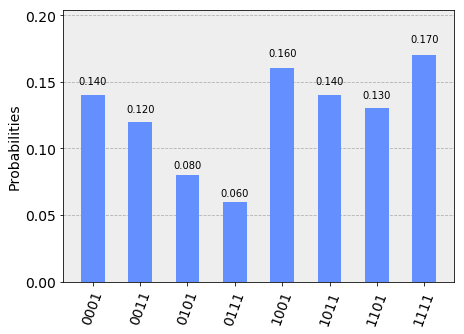

In [5]:
qc_1i = encode_bitstring(BS1, qr, cr, True)
qc_1i.measure(qr, cr)
job = execute(qc_1i , backend=backend, shots=shots)
st = job.result().get_counts()
plot_histogram(st)

In [8]:
decode_bitstring(st)

'11111111'

> **(??? 4)**
> 
> Why the inverted string consist only with 1? I've exptected it to be: 10000001 > 01111110

## Comparing the BS1 with BS1_inverted

Let's denote $|BS1>$ as the superpostion state created by the `encode_bitstring(BS1, ...)` and $ |BS1_i> $ as the superpostion state created by the `encode_bitstring(BS1, ..., inverse=True)`. This states are orthogonal if:
$$ <BS1|BS1_i> = 0 $$

In [ ]:
qc_1 = encode_bitstring(BS1, qr, cr)
qc_1.barrier(qr)
qc_1i = encode_bitstring(BS1, qr, cr, True)
qc_1i.measure(qr, cr)
qc_comb = qc_1 + qc_1i
job = execute(qc_comb , backend=backend, shots=shots)
st = job.result().get_counts()
plot_histogram(st)

The initial state of any circuit is represented by `0` for all it's qubits. So in our case `0000` is the initial state of the circut - all the qubits are `0`, so far no position is set (for the first three qubits, and no data is set for the last qubit). In the initial state of the circut we don't interpreted the `0000` as the `0` bit on the first postion of the bit string.

Analising the quantum algorithm step by step:

1. We start with the initial state of the circut `0000`.
2. We initialize the circut with the BS1 string. Now the state of the circut represents the bit string.
3. We input the inverted bitstring and in the effect we get the circut back to the initial state which is `0000`. 

In the quantum program above there is new instruction `barrier`. This command ensures that all instructions
listed after occur (in time) after all instructions listed before
the `barrier` [1](#bib_1).

## Comparing the BS1 with BS2_inverted

**TODO** We can write:
$$ |BS2> = a|BS1> + b|other\_state> $$
$$ |BS2> = a|BS1> + b|BS2_i> $$
$$ |BS1> = a|BS1> + b|BS1_i> $$
$$ |oth> = a|BS1> + b|BS2_i> $$
$$ |oth> = <BS1|BS2_i> $$


Check it...

In [ ]:
qc_1 = encode_bitstring(BS1, qr, cr)
qc_1.barrier(qr)
qc_2i = encode_bitstring(BS2, qr, cr, True)
qc_2i.measure(qr, cr)
qc_comb = qc_1 + qc_2i
job = execute(qc_comb , backend=backend, shots=shots)
st = job.result().get_counts()
plot_histogram(st)

Let's denote $ |BS1> $ as the superpostion state created by the `encode_bitstring(BS1, ...)` and $ |BS2> $ as the 
By looking only on state 0000 (the initial state) we get information how simmilar are the two bitstrings.

> (**??? 5**)
> Does the other states has any meaning?

## Bibliografy

<a name='bib_1'>[1]</a> https://arxiv.org/pdf/1809.03452.pdf